# Block 1: Introduction to Image Analysis
In this notebook you will see a short introduction to the PyTorch machine learning framework. Tensorflow (2.0) is quite similar to PyTorch in usage and naming convention.

Let us first import what we need to get started:

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from PIL import Image

## Part 1: The Tensor
PyTorch's central object is also the tensor: an array with arbitrary dimension with lots of functionalities and inbuild optimization for speed. It can be created in a number of different ways:

In [2]:
from_list = torch.tensor([[1, 2], [3, 4], [5, 6]])

np_array = np.array([[1, 2, 3], [4, 5, 6]])  # This could be an image read and preprocessed outside of torch
from_numpy = torch.from_numpy(np_array)

print(from_list)
print(from_numpy)

tensor([[1, 2],
        [3, 4],
        [5, 6]])
tensor([[1, 2, 3],
        [4, 5, 6]])


Tensors have a number of different properties but we can only cover the most important ones: The shape, the type, and the device of the tensor:

In [3]:
x = torch.tensor([[1.1, 2.0], [3.6, 4.8], [5.2, 6.3]])   # initializing with float will make it a float tensor
print(f'Shape: {x.shape}, dtype: {x.dtype}, device: {x.device}')

y = torch.tensor([[1, 2, 3], [4, 5, 6]])  # with integers it will use an int type
print(f'Shape: {y.shape}, dtype: {y.dtype}, device: {y.device}')

z = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=float)  # we can also explicitly create a tensor of a certain type
print(f'Shape: {z.shape}, dtype: {z.dtype}, device: {z.device}')

Shape: torch.Size([3, 2]), dtype: torch.float32, device: cpu
Shape: torch.Size([2, 3]), dtype: torch.int64, device: cpu
Shape: torch.Size([3, 3]), dtype: torch.float64, device: cpu


PyTorch tensors also come with a bunch of useful inbuilt functions, here we will show some of the most prominent examples:

| Functions | Description |
| --- | --- |
| `reshape` | Tensors can be reshaped to an arbitrary shape, as long as the product of new dimensions is the same as the product of the old (=number of entries in the tensor) |
| `view` | |
| `flatten` | Similar to reshape it changes the shape; it's a shorthand notice to reduce the tensor to one dimension |
| `min, mean, max` | Just like numpy arrays you can extract a bunch of metrics out-of-the-box from tensors, even for just a specific dimension in the tensor. **A key difference is that the PyTorch equivalent for extrema returns the value and index at the same time if you specify a specific dimension, i.e. min and argmin.** |
| `numpy` | Tensors can be transformed to normal numpy arrays. That's very useful as many other Pytorch libraries don't support Torch but do support numpy. One example is logging the loss.
| `to, cpu, cuda` | With these function you can move the memory location of a tensor; `.cpu()` and `.cuda()` are just shorthand notations for `.to('cpu')` and  `.to('cuda:0')` (depending on default GPU if several are available). These functions are very important when you use GPU acceleration (or multiple GPUS). It works not only for tensors but also pyTorch modules. A module that has been moved to the GPU also expects GPU tensors as input. Moreover, GPU operations have different error emssages so sometimes it might make sense to move a model to the CPU instead for debugging purposes. |

As a rule of thumb: Many methods that numpy arrays have also exist for PyTorch tensors, sometimes with a different name and often with parameters named differently (i.e. `axis` often becomes `dim`).

In [4]:
print(f'x shape original: {x.shape},\n {x}\n') 
a = x.reshape(3, 2)  # We can reshape it to 3,2 as 3*2 = 6 = 2*3 (original)
print(f'x reshaped to 3, 2: {a.shape}\n{a}\n')
b = x.flatten()
print(f'x flattened: {b.shape}\n{b}\n')

print(f'mean of x: {x.mean()}\nmin per row: {x.min(dim=0)}\nmax per column: {x.max(dim=1)}')

x shape original: torch.Size([3, 2]),
 tensor([[1.1000, 2.0000],
        [3.6000, 4.8000],
        [5.2000, 6.3000]])

x reshaped to 3, 2: torch.Size([3, 2])
tensor([[1.1000, 2.0000],
        [3.6000, 4.8000],
        [5.2000, 6.3000]])

x flattened: torch.Size([6])
tensor([1.1000, 2.0000, 3.6000, 4.8000, 5.2000, 6.3000])

mean of x: 3.8333332538604736
min per row: torch.return_types.min(
values=tensor([1.1000, 2.0000]),
indices=tensor([0, 0]))
max per column: torch.return_types.max(
values=tensor([2.0000, 4.8000, 6.3000]),
indices=tensor([1, 1, 1]))


In [5]:
x_np = x.numpy()
print(f'x_np dtype: {x_np.dtype}')

# This will only work if cuda is configured
if torch.cuda.is_available():
    x_gpu = x.cuda()
    print(f'x_gpu device: {x_gpu.device}')
else:
    print('Cuda not configured or no GPU')

x_np dtype: float32
x_gpu device: cuda:0


## Part 2: Models and Data
### Our model
We can define new network architectures very quickly. In the following example we will create a small one-layered **fully connected** network. It follows the equation
$$
y = W \cdot x + b \\
o = \text{Softmax}(y)
$$
Here $x$ stands for the input while $y$ is the output of the linear layer and $o$ the output of the Softmax activation function and the network itself. However, it is very common to call both $y$ and $o$ also $x$ in the code; in this way, $x$ is overwritten constantly which means we reuse its memory. Since image analysis often requires very large input (due to the 2D images), saving memory is quite important. The only exception to that rule is when you reuse the input or the output of an intermediate layer somewhere later and thus shouldn't overwrite it.

In [6]:
class MnistClassifier(torch.nn.Module):
    def __init__(self, in_features:int, out_features:int):
        super().__init__()
        self.flatten = torch.nn.Flatten(start_dim=1)  # Flatten everything past the first (batch) dimension
        self.fc = torch.nn.Linear(in_features, out_features)
        self.softmax = torch.nn.Softmax(dim=1)
        
        # Optionally, you could combine the layers above; however, for debugging this can be disadvantageous
        # In this case, you would remove the 'self.' calls above and only have this one class attribute
        # self.model = torch.nn.Sequential(flatten, fc, softmax)
        

    def forward(self, x:torch.tensor):
        x = self.flatten(x)
        x = self.fc(x)
        x = self.softmax(x)
        
        # x = self.model(x)  # this is the optional way if you use sequential
        return x

### The Data
Now that we have our small network, let's have a look at the data. We can easily get MNIST via torchvision:

In [7]:
train_ds = torchvision.datasets.MNIST(root='../../data/', train=True, download=True,
                                     transform=torchvision.transforms.ToTensor())  # We want tensors instead of raw data

test_ds = torchvision.datasets.MNIST(root='../../data/', train=False, download=True,
                                    transform=torchvision.transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw



/home/lbodden/conda/envs/rwth/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


After downloading the data, we should first have a look at it to see what we're dealing with. We can use what we've learned above; however, our data might need some preprocessing first:

Shape: torch.Size([1, 28, 28]), dtype: torch.float32
mean: 0.1376800686120987
min: 0.0
max: 1.0


Text(0.5, 1.0, 'Class: 5')

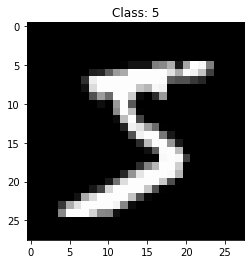

In [8]:
img, cl = train_ds[0]

# Let's first look at the shape and dtype
print(f'Shape: {img.shape}, dtype: {img.dtype}')

# Now we can look at its statistics
print(f'mean: {img.mean()}\nmin: {img.min()}\nmax: {img.max()}')

# Let's also plot it to see the actual data in a graph with axis ticks
# Since we've got an uncessary extra unary dimension at the start, we index it
plt.imshow(img[0], cmap='gray')
plt.title(f'Class: {cl}')


## Part 3: Training & Testing
Now that we have our model, data and preprocessor it's time to put them into action. For that, we have to create an instance of our model and outfit it with a loss and optimizer. Additionally, we create data loaders which package the data into batches.

In [9]:
num_epochs = 10
batch_size = 64
torch.manual_seed(42)

net = MnistClassifier(28*28, 10)
optimizer = torch.optim.Adam(params=net.parameters())
loss = torch.nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size)

model_params =  sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'Learnable model parameters: {model_params}')

Learnable model parameters: 7850


Finally, all that's left is our training and testing loops. There are libraries that extend PyTorch with more "user-friendly" functionalities, such as the commendable PyTorch Lightning. However, many more complex ML models still require that you design most parts of the training and testing loop yourself.
Usually, the training procedure has a nested loop structure: An outer loop for training epochs and inner loops for training and testing or alternatively, validation. To keep it simple we will only implement training and testing here:

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train batches:   0%|          | 0/938 [00:00<?, ?it/s]

Test batches:   0%|          | 0/157 [00:00<?, ?it/s]

Train batches:   0%|          | 0/938 [00:00<?, ?it/s]

Test batches:   0%|          | 0/157 [00:00<?, ?it/s]

Train batches:   0%|          | 0/938 [00:00<?, ?it/s]

Test batches:   0%|          | 0/157 [00:00<?, ?it/s]

Train batches:   0%|          | 0/938 [00:00<?, ?it/s]

Test batches:   0%|          | 0/157 [00:00<?, ?it/s]

Train batches:   0%|          | 0/938 [00:00<?, ?it/s]

Test batches:   0%|          | 0/157 [00:00<?, ?it/s]

Train batches:   0%|          | 0/938 [00:00<?, ?it/s]

Test batches:   0%|          | 0/157 [00:00<?, ?it/s]

Train batches:   0%|          | 0/938 [00:00<?, ?it/s]

Test batches:   0%|          | 0/157 [00:00<?, ?it/s]

Train batches:   0%|          | 0/938 [00:00<?, ?it/s]

Test batches:   0%|          | 0/157 [00:00<?, ?it/s]

Train batches:   0%|          | 0/938 [00:00<?, ?it/s]

Test batches:   0%|          | 0/157 [00:00<?, ?it/s]

Train batches:   0%|          | 0/938 [00:00<?, ?it/s]

Test batches:   0%|          | 0/157 [00:00<?, ?it/s]

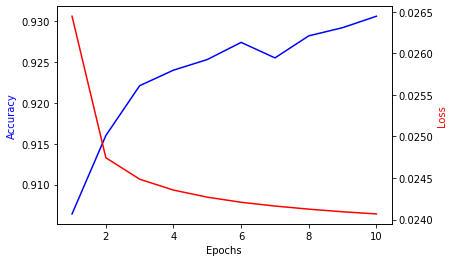

In [10]:
accuracy = []
epoch_losses = []

for e in tqdm(range(num_epochs), leave=False, desc='Epochs'):
    
    ########## Training 
    losses = torch.zeros(len(train_ds))
    for idx, (img_batch, cls_batch) in enumerate(tqdm(train_loader, leave=False, desc='Train batches')):
        optimizer.zero_grad()
        out = net(img_batch)  # forward pass

        l = loss(out, cls_batch)
        l.backward()  # backward pass
        optimizer.step()
        losses[idx] = l.detach()

    ########## Testing
    true_positives = 0

    with torch.no_grad():  # Since we don't optimize on the test set, we don't need a gradient here
        for idx, (img_batch, cls_batch) in enumerate(tqdm(test_loader, leave=False, desc='Test batches')):
            out = net(img_batch)  # forward pass
            _, prediction = out.max(dim=1)

            true_positives += (prediction == cls_batch).sum()

    accuracy.append(true_positives/len(test_ds))
    epoch_losses.append(torch.mean(losses).numpy())
     

epochs = np.arange(1, num_epochs+1)
fig, ax = plt.subplots()
ax.plot(epochs, accuracy, label='Accuracy', color='blue')

ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy', color='blue')

ax2 = ax.twinx()
ax2.plot(epochs, epoch_losses, label='Loss', color='red')
ax2.set_ylabel('Loss', color='red')

plt.show()

You have now taken your first steps into PyTorch territory. This was only a glimpse of what you can do in PyTorch but we will look more into it in the following sessions!

# Exercises

In this exercise, we will play around a bit with the hyperparameters of our model and then change its structure slightly. To make this more conventient, we will put our train code in a function with some helpful extras.

In [11]:
def train(batch_size:int=64, learning_rate:float=0.001, num_epochs:int=10, 
          net=MnistClassifier(28*28, 10), verbose=False):
    
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate)
    loss = torch.nn.CrossEntropyLoss()

    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size)


    accuracy = []
    epoch_losses = []

    for e in tqdm(range(num_epochs), leave=False, desc='Epochs'):

        ########## Training 
        losses = torch.zeros(len(train_ds))
        for idx, (img_batch, cls_batch) in enumerate(tqdm(train_loader, leave=False, desc='Train batches')):
            optimizer.zero_grad()
            out = net(img_batch)  # forward pass

            l = loss(out, cls_batch)
            l.backward()  # backward pass
            optimizer.step()
            losses[idx] = l.detach()

        ########## Testing
        true_positives = 0

        with torch.no_grad():  # Since we don't optimize on the test set, we don't need a gradient here
            for idx, (img_batch, cls_batch) in enumerate(tqdm(test_loader, leave=False, desc='Test batches')):
                out = net(img_batch)  # forward pass
                _, prediction = out.max(dim=1)

                true_positives += (prediction == cls_batch).sum()

        accuracy.append(true_positives/len(test_ds))
        epoch_losses.append(torch.mean(losses).numpy())


    epochs = np.arange(1, num_epochs+1)
    fig, ax = plt.subplots()
    ax.plot(epochs, accuracy, label='Accuracy', color='blue')

    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy', color='blue')

    ax2 = ax.twinx()
    ax2.plot(epochs, epoch_losses, label='Loss', color='red')
    ax2.set_ylabel('Loss', color='red')

    plt.show()
    
    return accuracy[-1], epoch_losses[-1]        

## Exercise 1
Set the batch size to $[32, 128]$ and the learning rate to $[0.1, 0.0001]$ and train the network (4 training runs in total).

## Exercise 2
Extend our one-layered MnistClassifier to a *Multilayer Perceptron* by **adding another linear layer** as hidden layer. As an activation function layer, use the **ReLU** in `torch.nn` (or with a slightly different use, in `torch.nn.functional`). After you instantiated the model, print the model parameters as we have done in the lesson code.

**Hint**: The output of the hidden layer has to fit to the input of the existing linear layer in terms of number of features.

In [12]:
class MnistMLP(torch.nn.Module):
    def __init__(self, in_features:int, hidden_features:int, out_features:int):
        super().__init__()
        self.flatten = torch.nn.Flatten(start_dim=1) 
        
        # Add a hidden layer and an activation function
        
        
        self.fc = torch.nn.Linear(in_features, out_features)  # You have to change something here
        self.softmax = torch.nn.Softmax(dim=1)
        


    def forward(self, x:torch.tensor):
        x = self.flatten(x)
        
        # Don't forget to call it down here
        
        x = self.fc(x)
        x = self.softmax(x)
        
        return x

Create an instance of our network and train it with a learning rate of $10^{-3}$ and a batch size of 64 for 15 epochs.

In [13]:
torch.manual_seed(0)
